# Credit risk prediction and explainability with Amazon SageMaker Clarify

![Credit risk explainability use case](credit_risk_prediction.png)

1. [Overview](#Overview)
1. [Prerequisites and Data](#Prerequisites-and-Data)
    1. [Initialize SageMaker](#Initialize-SageMaker) 
    1. [Data inspection](#Data-inspection) 
1. [Deploy Model](#Train-XGBoost-Model)
1. [Amazon SageMaker Clarify](#Amazon-SageMaker-Clarify)
    1. [Explaining Predictions](#Explaining-Predictions)
        1. [Viewing the Explainability Report](#Viewing-the-Explainability-Report)
        2. [Explaining individual bad credit prediction example](#Explaining-individual-prediction)
    2. [Understanding Bias](#Bias-Detection)
        1. [Pre-training bias metrics](#pre-training)
        2. [Post-training bias metrics](#post-training)
1. [Clean Up](#Clean-Up)

## Overview
Amazon SageMaker helps data scientists and developers to prepare, build, train, and deploy high-quality machine learning (ML) models quickly by bringing together a broad set of capabilities purpose-built for ML.

[Amazon SageMaker Clarify](https://aws.amazon.com/sagemaker/clarify/) helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models. 

Amazon SageMaker provides pre-made images for machine and deep learning frameworks for supported frameworks such as Scikit-Learn, XGBoost, TensorFlow, PyTorch, MXNet, or Chainer. These are preloaded with the corresponding framework and some additional Python packages, such as Pandas and NumPy, so you can write your own code for model training. See [here](https://docs.aws.amazon.com/sagemaker/latest/dg/algorithms-choose.html#supported-frameworks-benefits) for more information.


[Amazon SageMaker Studio](https://aws.amazon.com/sagemaker/studio/) provides a single, web-based visual interface where you can perform all ML development activities including notebooks, experiment management, automatic model creation, debugging, and model and data drift detection.

In this SageMaker Studio notebook, we highlight how you can use SageMaker to train models, host them as an inference pipeline, and provide bias detection and explainability to analyze data and understand prediction outcomes from the model.
This sample notebook walks you through:  

1. explore credit risk dataset - [South German Credit (UPDATE) Data Set](https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29)
2. Build an inference pipeline model (sklearn model and XGBoost model together) to preprocess input data and produce a prediction outcome per instance
3. Hosting and scoring the single model (Optional)
4. Single SageMaker Clarify job to provide Kernel SHAP values for the SageMaker model on training and test datasets.

![Credit risk explainability model inference](clarify_inf_pipeline_arch.png)

## Prerequisites and Data
### Initialize SageMaker

In [1]:
from io import StringIO
import os
import time
import sys
import IPython
from time import gmtime, strftime

import boto3
import numpy as np
import pandas as pd
import urllib

import sagemaker
from sagemaker.s3 import S3Uploader
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost import XGBoost
from sagemaker.s3 import S3Downloader
from sagemaker.s3 import S3Uploader
from sagemaker import Session
from sagemaker import get_execution_role
from sagemaker.xgboost import XGBoostModel
from sagemaker.sklearn import SKLearnModel
from sagemaker.pipeline import PipelineModel


session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/sagemaker-clarify-credit-risk-model"
region = session.boto_region_name

# Define IAM role
role = get_execution_role()

### Breif look at the data

In [2]:
credit_columns = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
    "credit_risk",
]

In [3]:
training_data = pd.read_csv(
    "data/SouthGermanCredit.asc",
    names=credit_columns,
    header=0,
    sep=r" ",
    engine="python",
    na_values="?",
).dropna()

print(training_data.head())

   status  duration  credit_history  purpose  amount  savings  \
0       1        18               4        2    1049        1   
1       1         9               4        0    2799        1   
2       2        12               2        9     841        2   
3       1        12               4        0    2122        1   
4       1        12               4        0    2171        1   

   employment_duration  installment_rate  personal_status_sex  other_debtors  \
0                    2                 4                    2              1   
1                    3                 2                    3              1   
2                    4                 2                    2              1   
3                    3                 3                    3              1   
4                    3                 4                    3              1   

   ...  property  age  other_installment_plans  housing  number_credits  job  \
0  ...         2   21                        3  

### Create the raw training and test CSV files

In [4]:
# prepare raw test data
test_data = training_data.sample(frac=0.1)
test_data = test_data.drop(["credit_risk"], axis=1)
test_filename = "test.csv"
test_columns = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
]
test_data.to_csv(test_filename, index=False, header=True, columns=test_columns, sep=",")

# prepare raw training data
train_filename = "train.csv"
training_data.to_csv(train_filename, index=False, header=True, columns=credit_columns, sep=",")

###  Upload Data to S3 as SageMaker functions expect the data to be located there 

In [5]:
test_raw = S3Uploader.upload(test_filename, "s3://{}/{}/data/test".format(bucket, prefix))
print(test_raw)

s3://sagemaker-us-west-2-328296961357/sagemaker/sagemaker-clarify-credit-risk-model/data/test/test.csv


In [6]:
train_raw = S3Uploader.upload(train_filename, "s3://{}/{}/data/train".format(bucket, prefix))
print(train_raw)

s3://sagemaker-us-west-2-328296961357/sagemaker/sagemaker-clarify-credit-risk-model/data/train/train.csv


### Using SageMaker Processing jobs for preprocessing

We will use SageMaker Processing jobs to perform the preprocessing on the raw data. SageMaker Processing provides prebuilt container for SKlearn which we will use here. We will output a sklearn model that can be used for preprocessing inference requests. 

In [7]:
sklearn_processor = SKLearnProcessor(
    role=role,
    base_job_name="sagemaker-clarify-credit-risk-processing-job",
    instance_type="ml.m5.large",
    instance_count=1,
    framework_version="0.20.0",
)

Let us have a look at the preprocessing script prepared to run in the processing job

In [8]:
#!pygmentize processing/preprocessor.py

In [9]:
#!pygmentize training/train_xgboost.py

## Create an Inference Pipeline

We will be deploying a SageMaker inference pipeline which will:
  1. Accept raw data as input
  1. preprocess the data with the SKlearn model we built earlier
  1. Pass the output of the Sklearn model as an input to the XGBoost model automatically
  1. Deliver the final inference result from the XGBoost model
  

To know more, check out the documentation on inference pipelines: https://docs.aws.amazon.com/sagemaker/latest/dg/inference-pipelines.html


### Retrieve model artifacts

First, we need to create two Amazon SageMaker Model objects, which associate the artifacts of training (serialized model artifacts in Amazon S3) to the Docker container used for inference. In order to do that, we need to get the paths to our serialized models in Amazon S3. We define the model data location of SKlearn and XGBoost models here.

In [10]:
model_path = session.upload_data(path='model', bucket=bucket, key_prefix="{}/model".format(prefix))
preprocessor_model_data = "{}/sklearn/model.tar.gz".format(model_path)
xgboost_model_data = "{}/xgb_model/model.tar.gz".format(model_path)
xgboost_inference_code_location = "{}/xgb_model/sourcedir.tar.gz".format(model_path)
sklearn_inference_code_location = "{}/sklearn/sourcedir.tar.gz".format(model_path)

### Create SKlearn Model Object

Next step is to create an `SKlearnModel` object which will contain the following important information:
  1. location of the sklearn model data
  1. our custom inference code
  1. SKlearn version to use (ensure this is the same the one used during pre-processing)

For hosting this model we provide a custom inference script, that is used to process the inputs and outputs and execute the transform.

The inference script is implemented in the `inference/sklearn/inference.py` file. The custom script defines:

- a custom `input_fn` for pre-processing inference requests. Our input function accepts only CSV input, loads the input in a Pandas dataframe and assigns feature column names to the dataframe
- a custom `predict_fn` for running the transform over the inputs
- a custom `model_fn` for deserializing the model

We will be using the default implementation of the `output_function` provided by SageMaker SKlearn container. To know more, check out: https://github.com/aws/sagemaker-scikit-learn-container



In [11]:
#!pygmentize inference/sklearn/inference.py



Now, let us define the SKLearnModel Object

In [12]:
sklearn_model = SKLearnModel(
    name="sklearn-model-{0}".format(str(int(time.time()))),
    model_data=preprocessor_model_data,
    entry_point="inference.py",
    source_dir="inference/sklearn/",
    code_location=sklearn_inference_code_location,
    role=role,
    sagemaker_session=session,
    framework_version="0.20.0",
    py_version="py3",
)
#https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html?highlight=SKLearnModel#deploy-an-endpoint-from-model-data

### XGBoost Model

Similarly to the previous steps, we can create an XGBoost model object. Also here, we have to provide a custom inference script.

The inference script is implemented in the `inference/xgboost/inference.py` file. The custom script defines:

- a custom `input_fn` for pre-processing inference requests. This input function is able to handle JSON requests, plus all content types supported by the default XGBoost container. For additional information please visit: https://github.com/aws/sagemaker-xgboost-container/blob/master/src/sagemaker_xgboost_container/encoder.py. The reason for adding the JSON content type is that the container-to-container default request content type in an inference pipeline is JSON.

- a custom `model_fn` for deserializing the model

Let us have a look at the inference script.



In [13]:
#!pygmentize inference/xgboost/inference.py

Now, let us define the XGBoost model Object


In [14]:
xgboost_model = XGBoostModel(
    name="xgb-model-{0}".format(str(int(time.time()))),
    model_data=xgboost_model_data,
    entry_point="inference.py",
    source_dir="inference/xgboost/",
    code_location=xgboost_inference_code_location,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
    sagemaker_session=session,
)
#https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/using_xgboost.html#bring-your-own-model


## Pipeline Model

Once we have models ready, we can deploy them in a pipeline, by building a PipelineModel object and calling the deploy() method.

In [15]:
pipeline_model_name = "credit-risk-inference-pipeline-{0}".format(str(int(time.time())))

pipeline_model = PipelineModel(
    name=pipeline_model_name,
    role=role,
    models=[sklearn_model, xgboost_model],
    sagemaker_session=session,
)

### Take note of the `model name` as it will be required while setting up the explainability job.

In [16]:
pipeline_model.name

'credit-risk-inference-pipeline-1643922031'

### Deploy Model 

Let's deploy the model and test the inference pipeline.

In [17]:
%%time
endpoint_name = "credit-risk-pipeline-endpoint-{0}".format(str(int(time.time())))
print(endpoint_name)

pipeline_model.deploy(
    initial_instance_count=1, instance_type="ml.m5.xlarge", endpoint_name=endpoint_name
)

credit-risk-pipeline-endpoint-1643922031
---------------!CPU times: user 275 ms, sys: 18.4 ms, total: 294 ms
Wall time: 7min 32s


### Inference

Now that the model has been deployed, lets us optionally test it against the raw test data we created earlier in this notebook.

In [18]:
test_dataset = S3Downloader.read_file(test_raw)

predictor = sagemaker.predictor.Predictor(
    endpoint_name,
    session,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

predictions = predictor.predict(test_dataset)
predictions

[['0.5875018'],
 ['0.85248965'],
 ['0.8437152'],
 ['0.12168857'],
 ['0.6632223'],
 ['0.92571104'],
 ['0.8298263'],
 ['0.7752831'],
 ['0.9695588'],
 ['0.92881185'],
 ['0.28275123'],
 ['0.18700601'],
 ['0.9439246'],
 ['0.34530458'],
 ['0.83813596'],
 ['0.83520734'],
 ['0.8992819'],
 ['0.43857595'],
 ['0.5932492'],
 ['0.4076552'],
 ['0.85055923'],
 ['0.9433851'],
 ['0.6640022'],
 ['0.6450452'],
 ['0.94264805'],
 ['0.6873149'],
 ['0.24660957'],
 ['0.71351063'],
 ['0.7661559'],
 ['0.9669233'],
 ['0.90636957'],
 ['0.4003488'],
 ['0.8728044'],
 ['0.40572768'],
 ['0.902082'],
 ['0.20535305'],
 ['0.14193079'],
 ['0.729455'],
 ['0.84485435'],
 ['0.87553793'],
 ['0.62361914'],
 ['0.7483827'],
 ['0.927023'],
 ['0.84442997'],
 ['0.9763338'],
 ['0.9075877'],
 ['0.8705956'],
 ['0.87108773'],
 ['0.8087902'],
 ['0.9315523'],
 ['0.9517077'],
 ['0.5543314'],
 ['0.66186124'],
 ['0.30824164'],
 ['0.62805104'],
 ['0.94486105'],
 ['0.87268984'],
 ['0.7495356'],
 ['0.37319663'],
 ['0.85293984'],
 ['0.14289594

## Amazon SageMaker Clarify
Now that you have your model set up. Let's say hello to SageMaker Clarify!

In [19]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.c4.xlarge", sagemaker_session=session
)

### Explaining Predictions
There are expanding business needs and legislative regulations that require explanations of _why_ a model made the decision it did. SageMaker Clarify uses [SHAP library](https://github.com/slundberg/shap) to explain the contribution that each input feature makes to the final decision. SageMaker Clarify uses a scalable and efficient implementation of [Kernel SHAP](https://github.com/slundberg/shap#model-agnostic-example-with-kernelexplainer-explains-any-function) with an option to use spark based parallelization with multiple processing instances. 

### Create a baseline for SHAP

As a contrastive explainability technique, SHAP values are calculated by evaluating the model on synthetic data generated against a baseline sample. The explanations of the same case can be different depending on the choices of this baseline sample. 

We are interested in explaining bad credit predictions. Hence, we would like the baseline choice to have E(x) closer to 1(belonging to the good credit class). 

We use the [mode](https://en.wikipedia.org/wiki/Mode_(statistics)) statistic to create the baseline. The mode is a good choice for categorical variables. We observe that the model prediction for the baseline has a high probability for the good credit class and hence it satisfies our requirement for the baseline. 

For more information on selecting informative vs non-informative baselines, see [SHAP Baselines for Explainability ](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html)

In [20]:
# load the raw training data in a data frame
raw_train_df = pd.read_csv("train.csv", header=0, names=None, sep=",")

# drop the target column
baseline = raw_train_df.drop(["credit_risk"], axis=1).mode().iloc[0].values.astype("int").tolist()

print(baseline)

[4, 24, 2, 3, 1258, 1, 3, 4, 3, 1, 4, 3, 27, 3, 2, 1, 3, 2, 1, 2]


In [21]:
# check baseline prediction E[(x)]
pred_baseline = predictor.predict(baseline)
print(pred_baseline)

[['0.78900737']]


### Setup configurations for Clarify

Next, setup some more configurations to start the explainability analysis by Clarify. We need to set up the following:
  1. **SHAPConfig**: to create the baseline. In this example, the mean_abs is the mean of absolute SHAP values for all instances, specified as the baseline
  
  
  1. **DataConfig**: to provide some basic information about data I/O to SageMaker Clarify. We specify where to find the input dataset, where to store the output, the header names, and the dataset type.
  1. **ModelConfig**: to specify information about the trained model here we re-use the model name created earlier
  
To know more about what these configurations mean for Clarify, check out the documentation here: https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-configure-processing-jobs.html




In [22]:
shap_config = clarify.SHAPConfig(
    baseline=[baseline],
    num_samples=2000,  # num_samples are permutations from your features, so should be large enough as compared to number of input features, for example, 2k + 2* num_features
    agg_method="mean_abs",
    use_logit=True,
)  # we want the shap values to have log-odds units so that the equation 'shap values + expected probability =  predicted probability' for each instance record )

In [23]:
explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)

explainability_data_config = clarify.DataConfig(
    s3_data_input_path=test_raw,
    s3_output_path=explainability_output_path,
    # label='credit_risk', # target column is not present in the test dataset
    headers=test_columns,
    dataset_type="text/csv",
)

In [24]:
model_config = clarify.ModelConfig(
    model_name=pipeline_model.name,  # specify the inference pipeline model name
    instance_type="ml.c5.xlarge",
    instance_count=1,
    accept_type="text/csv",
)

### Run SageMaker Clarify Explainability job

All the configurations are in place. Let's start the explainability job. This will spin up an ephemeral SageMaker endpoint and perform inference and calculate explanations on that endpoint. It does not use any existing production endpoint deployments.

In [25]:
%%time
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2022-02-03-21-08-05-134
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-328296961357/sagemaker/sagemaker-clarify-credit-risk-model/data/test/test.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-328296961357/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-328296961357/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainability', 'LocalPath

### Viewing the Explainability Report

Once the job is complete, you can view the explainability report in Studio under the 'Experiments and trials' tab

Look out for a trial component named 'clarify-explainability-' and see the Explainability tab. 

If you're not a Studio user yet, you can access this report at the following S3 bucket.

The report contains global explanations for the model with the input dataset

In [26]:
explainability_output_path

's3://sagemaker-us-west-2-328296961357/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainability'

## Analyze the results of Clarify 

In this section, we will analyze and understand the local explainability results for each individual prediction produced by Clarify. Clarify produces a CSV file which contains the SHAP value for each feature per prediction. Let us download the CSV.

In [27]:
from sagemaker.s3 import S3Downloader
import json
import io

# read the shap values
S3Downloader.download(s3_uri=explainability_output_path + "/explanations_shap", local_path="output")
shap_values_df = pd.read_csv("output/out.csv")
print(shap_values_df.shape)

(100, 20)


### Create a dataframe containing the model predictions

In [28]:
from pandas import DataFrame

predictions_df = DataFrame(predictions, columns=["probability_score"])

predictions_df

,probability_score
0,0.5875018
1,0.85248965
2,0.8437152
3,0.12168857
4,0.6632223
...,...
95,0.92820907
96,0.7170991
97,0.88844866
98,0.15628661


Note that by default SHAP explains classifier models in terms of their margin output, before the logistic link function. That means the units of SHAP output and are log-odds units, so negative values imply probabilities of less than 0.5 meaning bad credit class (class 0). 

E(y) is the log-odd (logit) unit for the prediction on the input baseline

y is the log-odd (logit) unit for the prediction output

SHAP values are in log-odd units as well 

The following is expected to hold true for every individual prediction : 

sum(SHAP values) + E(y)) == model_prediction_logit

logistic(model_prediction_logit) = model_prediction_probability

E(y) < 0 implies baseline probability less than 0.5 (bad credit baseline)

E(y) > 0 implies baseline probability greater than 0.5 (good credit baseline)

y < 0 implies predicted probability less than 0.5 (bad credit)

y > 0 implies predicted probability greater than 0.5 (good credit) 




We can retrieve E(y) , the log-odd unit of the prediction for the baseline input

In [29]:
# get the base expected value to be used to plot SHAP values
S3Downloader.download(s3_uri=explainability_output_path + "/analysis.json", local_path="output")

with open("output/analysis.json") as json_file:
    data = json.load(json_file)
    base_value = data["explanations"]["kernel_shap"]["label0"]["expected_value"]

print("base value: ", base_value)

base value:  1.3189524577840586


E(y) > 0  implies baseline probability greater than 0.5 (good credit baseline)

### Join the predictions, SHAP value and test data

Now, we create a single dataframe containing all test data rows, with their corresponding SHAP values and prediction score.

In [30]:
# join the probability score and shap values together in a single data frame
predictions_df.reset_index(drop=True, inplace=True)
shap_values_df.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

prediction_shap_df = pd.concat([predictions_df, shap_values_df, test_data], axis=1)
prediction_shap_df

,probability_score,status_label0,duration_label0,credit_history_label0,purpose_label0,amount_label0,savings_label0,employment_duration_label0,installment_rate_label0,personal_status_sex_label0,...,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,0.5875018,-1.719003e+00,-5.686732e-01,3.015172e-01,2.219901e-03,0.216437,3.856757e-04,6.185071e-01,2.827209e-01,3.367116e-03,...,2,1,25,3,2,2,3,2,1,2
1,0.85248965,-1.650943e+00,4.216102e-04,7.079010e-01,-2.312443e-04,0.514273,-1.911523e-04,8.427609e-01,-2.138527e-04,-1.452984e-03,...,2,2,48,3,2,2,2,2,1,2
2,0.8437152,-1.860326e+00,2.135656e-03,6.643984e-04,3.691677e-01,0.887377,5.772179e-01,4.871483e-01,2.163234e-01,-2.586409e-01,...,4,1,26,3,1,1,3,2,1,2
3,0.12168857,-2.461626e+00,-4.221790e-02,2.636204e-06,-8.931501e-02,0.027821,-4.109331e-03,-2.415131e-01,-3.087846e-03,-2.886717e-01,...,2,3,33,3,2,1,3,2,1,2
4,0.6632223,-1.226620e+00,2.703627e-03,-3.560366e-03,-1.184398e-03,0.064839,5.826316e-02,7.853448e-01,-4.466703e-04,-2.777158e-01,...,2,4,47,3,3,1,3,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.92820907,-4.324055e-09,-9.593052e-09,3.895833e-09,-8.282708e-09,0.360177,1.217658e-09,7.249437e-01,-8.654918e-11,1.592358e-08,...,2,3,28,3,2,1,3,2,2,2
96,0.7170991,-1.054679e+00,6.709268e-01,-2.594351e-01,-3.544882e-01,0.762014,9.070885e-03,-5.944074e-03,3.562853e-01,-3.539348e-01,...,2,3,36,2,2,2,3,2,2,2
97,0.88844866,-2.023886e-03,-2.509278e-01,-2.448107e-04,3.370438e-01,0.328693,4.058374e-01,-2.356951e-04,2.462817e-01,-2.330280e-03,...,3,3,26,3,2,1,3,2,1,2
98,0.15628661,-2.025591e+00,5.819618e-01,-5.100664e-03,-4.792690e-01,0.066512,3.087396e-02,-2.442060e-01,7.411140e-05,-3.473968e-01,...,2,2,23,1,2,1,2,2,1,2


There is a need to downcast the probability score as large precision values are not very useful in analysis.

In [31]:
prediction_shap_df["probability_score"] = pd.to_numeric(
    prediction_shap_df["probability_score"], downcast="float"
)

prediction_shap_df

,probability_score,status_label0,duration_label0,credit_history_label0,purpose_label0,amount_label0,savings_label0,employment_duration_label0,installment_rate_label0,personal_status_sex_label0,...,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,0.587502,-1.719003e+00,-5.686732e-01,3.015172e-01,2.219901e-03,0.216437,3.856757e-04,6.185071e-01,2.827209e-01,3.367116e-03,...,2,1,25,3,2,2,3,2,1,2
1,0.852490,-1.650943e+00,4.216102e-04,7.079010e-01,-2.312443e-04,0.514273,-1.911523e-04,8.427609e-01,-2.138527e-04,-1.452984e-03,...,2,2,48,3,2,2,2,2,1,2
2,0.843715,-1.860326e+00,2.135656e-03,6.643984e-04,3.691677e-01,0.887377,5.772179e-01,4.871483e-01,2.163234e-01,-2.586409e-01,...,4,1,26,3,1,1,3,2,1,2
3,0.121689,-2.461626e+00,-4.221790e-02,2.636204e-06,-8.931501e-02,0.027821,-4.109331e-03,-2.415131e-01,-3.087846e-03,-2.886717e-01,...,2,3,33,3,2,1,3,2,1,2
4,0.663222,-1.226620e+00,2.703627e-03,-3.560366e-03,-1.184398e-03,0.064839,5.826316e-02,7.853448e-01,-4.466703e-04,-2.777158e-01,...,2,4,47,3,3,1,3,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.928209,-4.324055e-09,-9.593052e-09,3.895833e-09,-8.282708e-09,0.360177,1.217658e-09,7.249437e-01,-8.654918e-11,1.592358e-08,...,2,3,28,3,2,1,3,2,2,2
96,0.717099,-1.054679e+00,6.709268e-01,-2.594351e-01,-3.544882e-01,0.762014,9.070885e-03,-5.944074e-03,3.562853e-01,-3.539348e-01,...,2,3,36,2,2,2,3,2,2,2
97,0.888449,-2.023886e-03,-2.509278e-01,-2.448107e-04,3.370438e-01,0.328693,4.058374e-01,-2.356951e-04,2.462817e-01,-2.330280e-03,...,3,3,26,3,2,1,3,2,1,2
98,0.156287,-2.025591e+00,5.819618e-01,-5.100664e-03,-4.792690e-01,0.066512,3.087396e-02,-2.442060e-01,7.411140e-05,-3.473968e-01,...,2,2,23,1,2,1,2,2,1,2


### Convert the probability score to binary prediction

Now, convert the probability scores to a binary value(1/0), based on a threshold(0.5), where probability scores greater than 0.5 are positive outcomes and lesser are negative outcomes.

In [32]:
# create a new column as 'Prediction' converting the probability score to either 1 or 0
prediction_shap_df.insert(
    0, "Prediction", (prediction_shap_df["probability_score"] > 0.5).astype(int)
)

prediction_shap_df

,Prediction,probability_score,status_label0,duration_label0,credit_history_label0,purpose_label0,amount_label0,savings_label0,employment_duration_label0,installment_rate_label0,...,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,1,0.587502,-1.719003e+00,-5.686732e-01,3.015172e-01,2.219901e-03,0.216437,3.856757e-04,6.185071e-01,2.827209e-01,...,2,1,25,3,2,2,3,2,1,2
1,1,0.852490,-1.650943e+00,4.216102e-04,7.079010e-01,-2.312443e-04,0.514273,-1.911523e-04,8.427609e-01,-2.138527e-04,...,2,2,48,3,2,2,2,2,1,2
2,1,0.843715,-1.860326e+00,2.135656e-03,6.643984e-04,3.691677e-01,0.887377,5.772179e-01,4.871483e-01,2.163234e-01,...,4,1,26,3,1,1,3,2,1,2
3,0,0.121689,-2.461626e+00,-4.221790e-02,2.636204e-06,-8.931501e-02,0.027821,-4.109331e-03,-2.415131e-01,-3.087846e-03,...,2,3,33,3,2,1,3,2,1,2
4,1,0.663222,-1.226620e+00,2.703627e-03,-3.560366e-03,-1.184398e-03,0.064839,5.826316e-02,7.853448e-01,-4.466703e-04,...,2,4,47,3,3,1,3,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0.928209,-4.324055e-09,-9.593052e-09,3.895833e-09,-8.282708e-09,0.360177,1.217658e-09,7.249437e-01,-8.654918e-11,...,2,3,28,3,2,1,3,2,2,2
96,1,0.717099,-1.054679e+00,6.709268e-01,-2.594351e-01,-3.544882e-01,0.762014,9.070885e-03,-5.944074e-03,3.562853e-01,...,2,3,36,2,2,2,3,2,2,2
97,1,0.888449,-2.023886e-03,-2.509278e-01,-2.448107e-04,3.370438e-01,0.328693,4.058374e-01,-2.356951e-04,2.462817e-01,...,3,3,26,3,2,1,3,2,1,2
98,0,0.156287,-2.025591e+00,5.819618e-01,-5.100664e-03,-4.792690e-01,0.066512,3.087396e-02,-2.442060e-01,7.411140e-05,...,2,2,23,1,2,1,2,2,1,2


### Filter out bad predictions

Since we interested in explaining negative outcomes (bad credit predictions) only in this exercise, we filter the records to keep only the record with prediction as 0.

In [33]:
bad_credit_outcomes_df = prediction_shap_df[prediction_shap_df.iloc[:, 0] == 0]
bad_credit_outcomes_df

,Prediction,probability_score,status_label0,duration_label0,credit_history_label0,purpose_label0,amount_label0,savings_label0,employment_duration_label0,installment_rate_label0,...,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
3,0,0.121689,-2.461626,-0.042218,0.000003,-0.089315,0.027821,-0.004109,-0.241513,-0.003088,...,2,3,33,3,2,1,3,2,1,2
10,0,0.282751,-1.853421,-0.084974,-0.186739,-0.417296,0.791994,0.332328,-0.249667,0.085492,...,3,3,28,3,2,2,3,2,1,2
11,0,0.187006,-1.862331,-0.768495,0.392396,0.004455,0.424114,-0.000074,-0.263421,0.001361,...,2,2,24,1,2,2,2,2,1,2
13,0,0.345305,-0.002004,-0.300328,-0.000066,-0.088915,-0.745171,-0.002736,-0.228303,-0.000423,...,2,3,26,3,2,2,4,2,2,2
17,0,0.438576,-2.124216,0.466007,0.001443,-0.401941,0.863734,-0.000568,0.003607,0.067826,...,2,2,29,3,2,1,3,2,2,2
19,0,0.407655,-1.759209,-0.407472,-0.000438,0.339944,-0.135741,0.005614,-0.132655,0.525147,...,4,3,28,3,1,1,4,2,2,2
26,0,0.246610,-2.440950,0.003517,-0.002456,-0.000018,0.531512,0.003171,-0.307822,-0.001254,...,3,2,32,3,2,1,3,2,1,2
31,0,0.400349,-1.976130,0.939753,-0.001761,-0.002729,0.069702,0.001549,-0.310630,0.086779,...,4,2,22,3,1,1,3,2,1,2
33,0,0.405728,-1.966652,0.699945,-0.001126,-0.539109,-0.002466,-0.000351,-0.206475,0.022485,...,1,3,25,3,1,1,3,2,1,2
35,0,0.205353,-2.294444,-0.001892,-0.318858,0.000670,0.600401,0.000050,-0.305820,0.004202,...,2,3,29,3,1,1,2,2,2,2


### Create SHAP plots 

Now we try to create some SHAP plots to understand how much different features contributed to the negative outcome.

#### Install open source SHAP library for more visualizations

In [34]:
!conda install -c conda-forge shap -y

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::aioitertools==0.7.1=pyhd8ed1ab_0
  - conda-forge/linux-64::importlib-metadata==3.7.0=py36h5fab9bb_0
  - conda-forge/noarch::typing-extensions==3.7.4.3=0
  - conda-forge/noarch::black==20.8b1=py_1
  - conda-forge/noarch::helpdev==0.7.1=pyhd8ed1ab_0
  - conda-forge/noarch::imageio==2.9.0=py_0
  - conda-forge/noarch::importlib_metadata==3.7.0=hd8ed1ab_0
  - conda-forge/linux-64::yarl==1.6.3=py36h8f6f2f9_1
  - conda-forge/noarch::flake8==3.8.4=py_0
  - conda-forge/noarch::jsonschema==3.2.0=py_2
  - conda-forge/linux-64::matplotlib-base==3.3.4=py36hd391965_0
  - conda-forge/linux-64::path==15.1.2=py36h5fab9bb_0
  - conda-forge/linux-64::pluggy==0.13.1=py36h5fab9bb_4
  - conda-forge/noarch::qdarkstyle==2.8.1=pyhd8ed1ab_2
  - conda-forge/linux-64::anyio==2.1.0=py36h5fab9bb_0
  - conda-forge/noarch::flask==1.1.2=pyh9f0ad

In [35]:
import shap

Matplotlib is building the font cache; this may take a moment.


#### SHAP summary plot for all individual bad credit prediction instance in the dataset

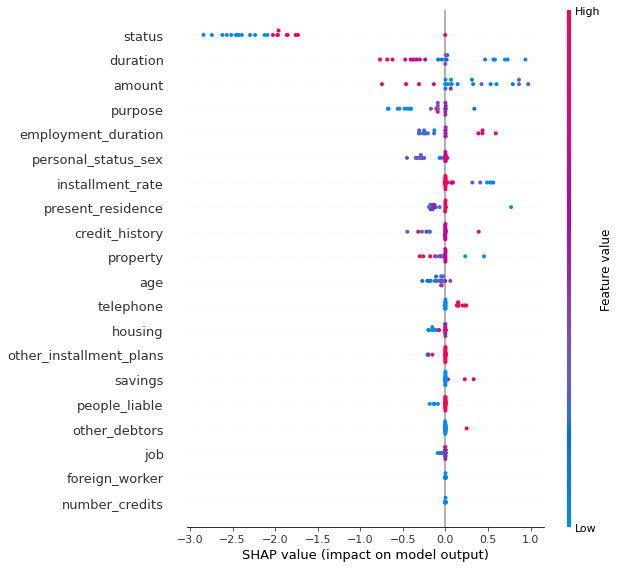

In [36]:
shap.summary_plot(
    bad_credit_outcomes_df.iloc[:, 2:22].to_numpy(),
    bad_credit_outcomes_df.iloc[:, 22:42].to_numpy(),
    feature_names=test_data.columns,
)

#### SHAP explanation plot for a single bad credit ensemble prediction instance 

In [37]:
import matplotlib.pyplot as plt

min_index = prediction_shap_df["probability_score"].idxmin()
print(min_index)
print("mean probability of dataset")
print(prediction_shap_df[["probability_score"]].mean())
print("individual probability")
print(prediction_shap_df.iloc[45, 1])
print("sum of shap values")
print(prediction_shap_df.iloc[45, 2:22].sum())
print("base value from analysis.json")
print(base_value)

72
mean probability of dataset
probability_score    0.699321
dtype: float32
individual probability
0.9075877
sum of shap values
0.9655776561326563
base value from analysis.json
1.3189524577840586


Example 'bad credit' prediction SHAP values.

In the chart below, f(x) is the prediction of this particular individual instance in log-odd units. If negative, it means it is a bad credit prediction. 

In the chart below, E(f(x)) is the prediction of the baseline input in log-odd units. It is positive , which means it belongs to the good credit class. 

The individual example is contrasted against the good credit baseline. So the features with negative SHAP values drive the final negative decision from the initial baseline positive value.




### In the below example, the input features (status = 1) , (purpose = 0) and (personal_status_sex = 2) are the top 3 features driving the negative decision. 

You can refer the data description to understand the mapping of these values to logical categories. 

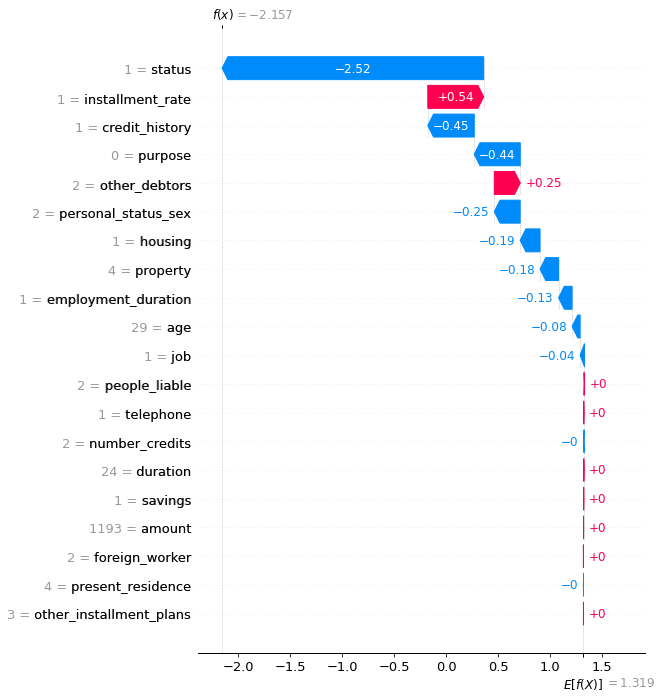

In [38]:
explanation_obj = shap._explanation.Explanation(
    values=prediction_shap_df.iloc[min_index, 2:22].to_numpy(),
    base_values=base_value,
    data=test_data.iloc[min_index].to_numpy(),
    feature_names=test_data.columns,
)
shap.plots.waterfall(shap_values=explanation_obj, max_display=20, show=True)

Feel free to change the min_index in the plot above to explain predictions of other individual instances

### Extra Exercise - Calculate Bias metrics

In [39]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_raw,
    s3_output_path=bias_report_output_path,
    label="credit_risk",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)
predictions_config = clarify.ModelPredictedLabelConfig(label=None, probability=0)

In [40]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1],
    facet_name="age",
    facet_values_or_threshold=[40],
    group_name="personal_status_sex",
)

### The clarify_processor.run_bias() below will take as long as 10 min to run. To save time, you can view pre-saved bias report in  clarify-bias/ directory as ipynb, html, or pdf file. 


%%time
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)

#### Viewing the Bias detection Report
You can view the bis detection report in Studio under the experiments tab 

If you're not a Studio user yet, you can access this report at the following S3 bucket.

In [41]:
bias_report_output_path

's3://sagemaker-us-west-2-328296961357/sagemaker/sagemaker-clarify-credit-risk-model/clarify-bias'

In [42]:
session.download_data (path='clarify-bias', bucket=bucket, key_prefix="{}/{}".format(prefix, 'clarify-bias'))

### Clean Up
Finally, don't forget to clean up the resources we set up and used for this demo!

In [43]:
session.delete_endpoint(endpoint_name)

In [44]:
session.delete_model(pipeline_model.name)